In [1]:
from google.colab import drive
drive.mount('/content/ggdrive')

Mounted at /content/ggdrive


In [2]:
import pandas as pd
df = pd.read_csv('/content/ggdrive/MyDrive/Đề án mô hình học máy dự đoán nợ xấu/processed_data.csv')
df

,TS_CREDIT_SCORE_V2,SoTienDKVayBanDau,TienGiaiNgan,SoTienConLai,LongestOverdue,NumberOfLoans,HasLatePayment,HasBadDebt,Gender,Birthday,...,Gender_1.0,Gender_Unknown,ReceiveYourIncomeSalary_Unknown,ReceiveYourIncomeSalary_chuyển khoản ngân hàng,ReceiveYourIncomeSalary_qua thẻ atm,ReceiveYourIncomeSalary_tiền mặt có phiếu lương,ReceiveYourIncomeSalary_tiền mặt từ khách hàng,ReceiveYourIncomeSalary_tiền mặt và không có phiếu lương,Residence_Ordinal,thoi_gian_da_song
0,-2,-0.009680,0.302716,-0.111862,0,-1,0,0,0.0,1987-12-16,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,5.0
1,-2,0.280125,-0.977802,-0.111862,11,-1,0,0,1.0,1987-12-16,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,6.0
2,-1,-0.524387,-0.448234,-0.113115,0,-1,0,0,0.0,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,5.0
3,0,-0.009680,0.109207,-0.111862,1,-1,0,0,0.0,1989-10-04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,5.0
4,1,-0.009680,0.109207,-0.111862,0,-1,0,0,1.0,1982-01-31,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,0,-0.524387,-0.448234,-0.024759,0,1,0,0,0.0,1996-12-09,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,2.0
2364,0,-0.730270,-0.671210,-0.036661,0,1,0,0,Unknown,NaN,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
2365,0,-0.421446,-0.336746,-0.111862,0,0,0,0,0.0,1991-11-09,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,2.0
2366,0,-0.318504,-0.336746,-0.111862,0,1,0,0,0.0,1985-12-02,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,2.0


In [3]:
!pip install xgboost
!pip install imblearn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
from collections import defaultdict

# Tạo danh sách 10 random seeds
random_seeds = [42, 123, 456, 789, 101, 202, 303, 404, 505, 606]

# Chọn đặc trưng và biến mục tiêu cho bài toán phân loại "HasBadDebt"
target = 'HasBadDebt'
features = [
    'TS_CREDIT_SCORE_V2', 'SoTienDKVayBanDau', 'TienGiaiNgan', 'SoTienConLai',
    'LongestOverdue', 'NumberOfLoans', 'HasLatePayment', 'Salary',
    'Age', 'TyLeNoSoVoiThuNhap', 'LoanDuration', 'Residence_Ordinal',
    'thoi_gian_da_song', 'JobName_LabelEncoded'
]

# Tạo bản sao dữ liệu đặc trưng và mục tiêu
X = df[features].copy()
y = df[target].copy()

# Xử lý giá trị khuyết
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
if len(num_cols) > 0:
    num_imputer = SimpleImputer(strategy='mean')
    X.loc[:, num_cols] = num_imputer.fit_transform(X[num_cols])
    X[num_cols] = X[num_cols].astype('float64')
else:
    print("\nKhông có cột số nào trong các đặc trưng đã chọn.")

cat_cols = X.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X.loc[:, cat_cols] = cat_imputer.fit_transform(X[cat_cols])
else:
    print("Không có cột phân loại nào trong các đặc trưng đã chọn.")

# Mã hóa biến phân loại
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Chuẩn hóa các đặc trưng dạng số
if len(num_cols) > 0:
    scaler = StandardScaler()
    X.loc[:, num_cols] = scaler.fit_transform(X[num_cols])

# Tạo từ điển để lưu kết quả trung bình
performance_avg = defaultdict(lambda: defaultdict(list))

# Lặp qua từng random seed
for seed in random_seeds:
    print(f"\nĐang chạy với random seed: {seed}")

    # Chia dữ liệu
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )

    # Tính scale_pos_weight cho XGBoost
    neg_samples = sum(y_train == 0)
    pos_samples = sum(y_train == 1)
    scale_pos_weight = neg_samples / pos_samples if pos_samples > 0 else 1

    # Khởi tạo các mô hình
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=seed, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(random_state=seed, n_estimators=100, class_weight='balanced'),
        'XGBoost': xgb.XGBClassifier(random_state=seed, scale_pos_weight=scale_pos_weight, eval_metric='logloss'),
        'SVM (Radial Kernel)': SVC(random_state=seed, kernel='rbf', probability=True, class_weight='balanced'),
        'SVM (Polynomial Kernel)': SVC(random_state=seed, kernel='poly', degree=3, probability=True, class_weight='balanced')
    }

    # Huấn luyện và đánh giá
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Tính các chỉ số
        performance_avg[name]['Accuracy'].append(accuracy_score(y_test, y_pred))
        performance_avg[name]['Precision'].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        performance_avg[name]['Recall'].append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
        performance_avg[name]['F1-Score'].append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

# Tính trung bình và độ lệch chuẩn cho các chỉ số
print("\nTổng kết hiệu suất trung bình các mô hình (10 random seeds):")
for name in performance_avg:
    print(f"\n{name}:")
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
        mean_val = np.mean(performance_avg[name][metric])
        std_val = np.std(performance_avg[name][metric])
        print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

Không có cột phân loại nào trong các đặc trưng đã chọn.

Đang chạy với random seed: 42

Đang chạy với random seed: 123

Đang chạy với random seed: 456

Đang chạy với random seed: 789

Đang chạy với random seed: 101

Đang chạy với random seed: 202

Đang chạy với random seed: 303

Đang chạy với random seed: 404

Đang chạy với random seed: 505

Đang chạy với random seed: 606

Tổng kết hiệu suất trung bình các mô hình (10 random seeds):

Decision Tree:
Accuracy: 0.8504 ± 0.0149
Precision: 0.8549 ± 0.0092
Recall: 0.8504 ± 0.0149
F1-Score: 0.8524 ± 0.0115

Random Forest:
Accuracy: 0.8892 ± 0.0070
Precision: 0.8575 ± 0.0228
Recall: 0.8892 ± 0.0070
F1-Score: 0.8559 ± 0.0094

XGBoost:
Accuracy: 0.8424 ± 0.0124
Precision: 0.8568 ± 0.0093
Recall: 0.8424 ± 0.0124
F1-Score: 0.8487 ± 0.0088

SVM (Radial Kernel):
Accuracy: 0.6730 ± 0.0185
Precision: 0.9038 ± 0.0058
Recall: 0.6730 ± 0.0185
F1-Score: 0.7342 ± 0.0151

SVM (Polynomial Kernel):
Accuracy: 0.6468 ± 0.0163
Precision: 0.9020 ± 0.0035
Recall: 

Code Deep Learning


>>> Phân tích SHAP (GradientExplainer) cho seed cuối cùng:

SHAP cho mô hình FNN:
Shape of shap_values: (5, 10)
Shape of data_to_plot: (5, 10)
Number of feature names provided: 10
Feature names match data shape.


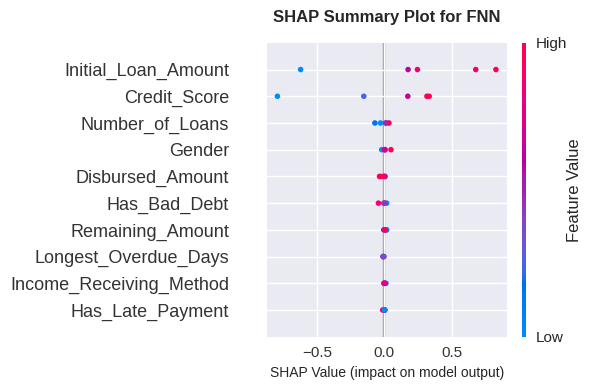

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



SHAP cho mô hình RNN:
Shape of shap_values: (5, 10)
Shape of data_to_plot: (5, 10)
Number of feature names provided: 10
Feature names match data shape.


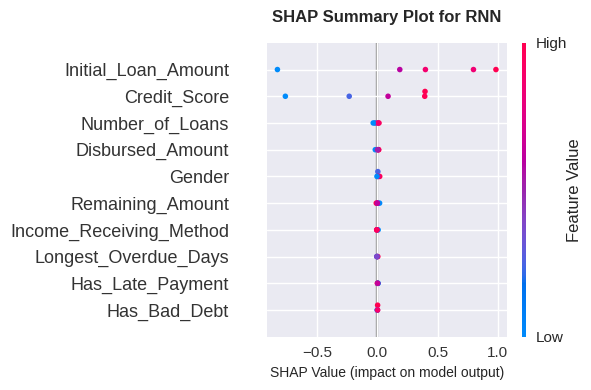

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 



SHAP cho mô hình GRU:
Shape of shap_values: (5, 10)
Shape of data_to_plot: (5, 10)
Number of feature names provided: 10
Feature names match data shape.


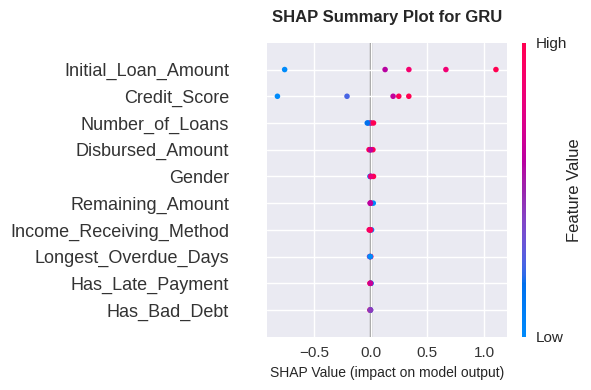

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



SHAP cho mô hình LSTM:
Shape of shap_values: (5, 10)
Shape of data_to_plot: (5, 10)
Number of feature names provided: 10
Feature names match data shape.


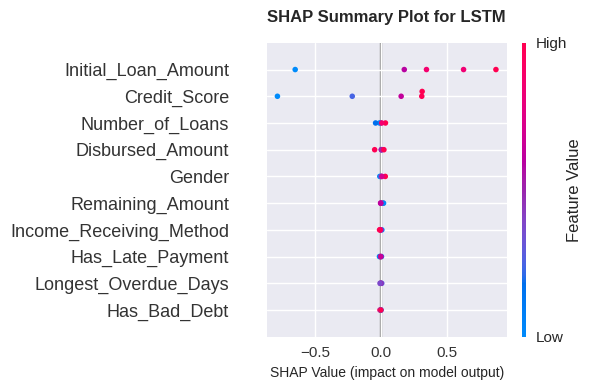

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [11]:
# Phân tích SHAP cho seed cuối cùng
print("\n>>> Phân tích SHAP (GradientExplainer) cho seed cuối cùng:")
np.random.seed(seed)
indices = np.random.choice(X_train.shape[0], 100, replace=False)
background_samples = X_train[indices]
background_samples_reshaped = X_train_reshaped[indices]

# Danh sách tên đặc trưng gốc (điều chỉnh còn 10 đặc trưng)
feature_names = [
    'Credit_Score', 'Initial_Loan_Amount', 'Disbursed_Amount', 'Remaining_Amount',
    'Longest_Overdue_Days', 'Number_of_Loans', 'Has_Late_Payment', 'Has_Bad_Debt',
    'Gender', 'Income_Receiving_Method'
]

for name, (model, test_data) in models.items():
    print(f"\nSHAP cho mô hình {name}:")

    try:
        # Chọn mẫu và tạo explainer
        if name == 'FNN':
            X_sample = X_test[:5]
            explainer = shap.GradientExplainer(model, background_samples)
            shap_values = explainer.shap_values(X_sample)
            shap_values_arr = shap_values[0] if isinstance(shap_values, list) else shap_values
            shap_values_2d = shap_values_arr.reshape(X_sample.shape[0], -1)
            data_to_plot = X_sample
        else:
            X_sample = X_test_reshaped[:5]
            explainer = shap.GradientExplainer(model, background_samples_reshaped)
            shap_values = explainer.shap_values(X_sample)
            shap_values_arr = shap_values[0] if isinstance(shap_values, list) else shap_values
            shap_values_2d = shap_values_arr.reshape(X_sample.shape[0], -1)
            data_to_plot = X_sample.reshape(X_sample.shape[0], -1)

        # Kiểm tra shape và debug
        print(f"Shape of shap_values: {shap_values_2d.shape}")
        print(f"Shape of data_to_plot: {data_to_plot.shape}")
        print(f"Number of feature names provided: {len(feature_names)}")

        # Đảm bảo số lượng tên đặc trưng khớp với dữ liệu
        if len(feature_names) > data_to_plot.shape[1]:
            feature_names_used = feature_names[:data_to_plot.shape[1]]
            print(f"Warning: Adjusted feature names to match data shape: {len(feature_names_used)} features")
        elif len(feature_names) < data_to_plot.shape[1]:
            print(f"Error: Data has more features ({data_to_plot.shape[1]}) than provided names ({len(feature_names)}). Using default names for extras.")
            feature_names_used = feature_names + [f'Feature_{i}' for i in range(len(feature_names), data_to_plot.shape[1])]
        else:
            feature_names_used = feature_names
            print("Feature names match data shape.")

        # Thiết lập style chung cho matplotlib
        plt.style.use('seaborn-v0_8')
        plt.rcParams['font.size'] = 10

        # Vẽ SHAP Summary Plot
        fig, ax = plt.subplots(figsize=(6, 4))
        shap.summary_plot(
            shap_values_2d,
            data_to_plot,
            feature_names=feature_names_used,
            show=False,
            plot_size=None,
            max_display=15,
            color_bar_label='Feature Value'
        )
        plt.title(f"SHAP Summary Plot for {name}", fontsize=12, pad=15, weight='bold')
        plt.xlabel("SHAP Value (impact on model output)", fontsize=10)
        plt.tight_layout()
        plt.savefig(f"/content/shap_summary_{name}.png", dpi=300, bbox_inches='tight', format='png')
        plt.show()
        plt.close(fig)

        # Tính giá trị kỳ vọng (base value) cho force plot
        if name == 'FNN':
            background_pred = model.predict(background_samples)
        else:
            background_pred = model.predict(background_samples_reshaped)
        expected_value = np.mean(background_pred, axis=0)
        if isinstance(expected_value, np.ndarray) and expected_value.size > 1:
            expected_value = expected_value[0]  # Lấy giá trị đầu tiên nếu là mảng đa chiều

        # (Tùy chọn) Force Plot tương tác (HTML)
        shap.initjs()
        shap.force_plot(
            expected_value,
            shap_values_2d[0],
            data_to_plot[0],
            feature_names=feature_names_used
        )

    except Exception as e:
        print(f"Lỗi khi tạo SHAP plot cho {name}: {str(e)}")

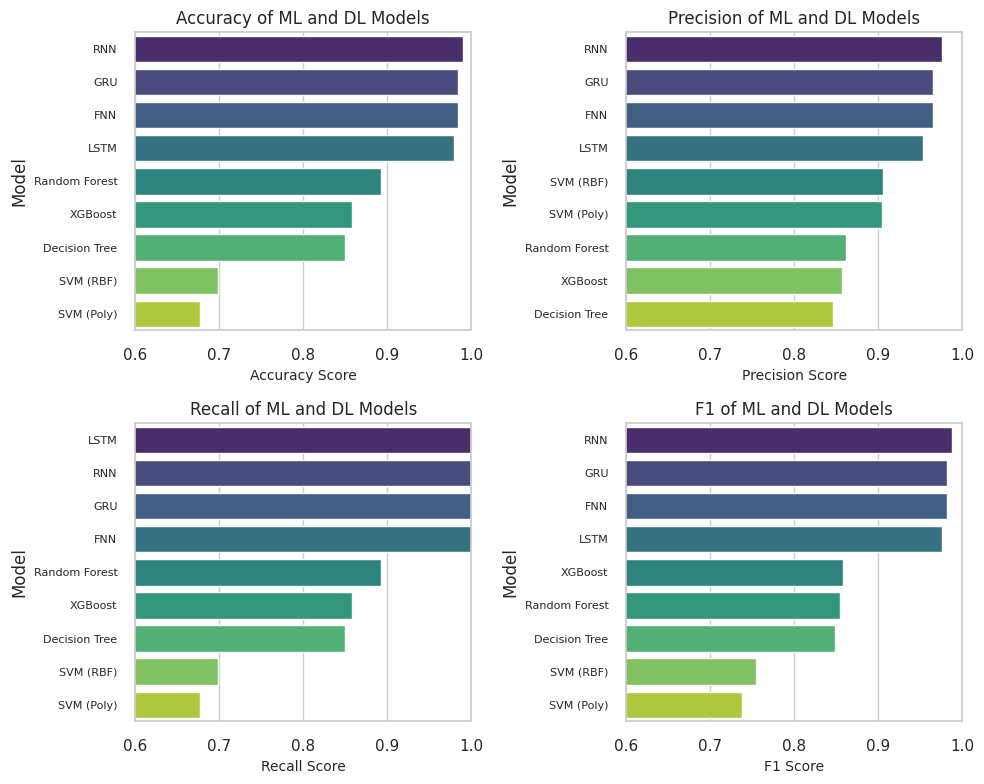

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import uuid

%matplotlib inline
sns.set_theme(style="whitegrid")

df1 = pd.DataFrame({
    'Model': [
        'Decision Tree', 'Random Forest', 'XGBoost',
        'SVM (RBF)', 'SVM (Poly)',
        'FNN', 'RNN', 'GRU', 'LSTM'
    ],
    'Accuracy': [0.8502, 0.8924, 0.8586, 0.6983, 0.6772, 0.9850, 0.9900, 0.9850, 0.9800],
    'Precision': [0.8464, 0.8615, 0.8575, 0.9060, 0.9042, 0.9651, 0.9765, 0.9651, 0.9540],
    'Recall': [0.8502, 0.8924, 0.8586, 0.6983, 0.6772, 1.0000, 1.0000, 1.0000, 1.0000],
    'F1': [0.8483, 0.8541, 0.8580, 0.7548, 0.7377, 0.9822, 0.9881, 0.9822, 0.9765]
})

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
sort_order = 'descending'
plt.figure(figsize=(10, 8))

for i, metric in enumerate(metrics, 1):
    # Sắp xếp dữ liệu theo metric
    sorted_df = df1.sort_values(by=metric, ascending=(sort_order == 'ascending'))

    plt.subplot(2, 2, i)
    ax = sns.barplot(x=metric, y='Model', data=sorted_df, palette='viridis')
    plt.title(f'{metric} of ML and DL Models', fontsize=12)
    plt.xlabel(f'{metric} Score', fontsize=10)  # Thêm tên rõ ràng cho trục hoành
    plt.ylabel('Model', fontsize=12)
    plt.xlim(0.6, 1.0)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

plt.tight_layout()
plt.show()